In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

In [5]:
np.random.seed(42)  # For reproducibility
T = 10000           # total time horizon

n_products = 3
n_intervals = 500

# Slightly Non Stationary Environment

### We will simulate a slightly non-stationary environment by partitioning the rounds into intervals. The distribution in each intervall will be costant and at each intervall the mean and standard deviation will be incremented by a quantity sampled from a distribution


In [ ]:
class NonStationaryEnvironment:

    def __init__(self, n_products, T, n_intervals, delta_mu = 0.05, delta_std = 0.01, mu_range=(0.3,0.7), std_range=(0.05,0.15), n_generator = None ):
        
        """Args:
           n_products: Number of products
           T: Number of timesteps
           n_intervals: Number of intervals for the non-stationary environment
           n_generator: Random number generator (optional, defaults to np.random.default_rng())"""
        
        self.n_products = n_products
        self.T = T
        self.n_intervals = n_intervals
        self.n_generator = n_generator if n_generator is not None else np.random.default_rng()
        self.mu_range = mu_range
        self.std_range = std_range
        self.delta_mu = delta_mu
        self.delta_std = delta_std

        self.interval_lenght = T // n_intervals


    def generate_valuations_parameters(self):
        "Generate mean and standard deviation for each product evaluation and for each timestep"

        #Initialize mean and std deviation matrix to all zeros
        means = np.empty((self.T, self.n_products))
        stds = np.empty((self.T, self.n_products))

        #starting mean and standard deviation
        prev_means = self.n_generator.uniform(low=self.mu_range[0], high=self.mu_range[1], size=self.n_products)
        prev_stds = self.n_generator.uniform(low=self.std_range[0], high=self.std_range[1], size=self.n_products)

        for i in range(self.n_intervals):
            start = i * self.interval_lenght
            end = (i+1) * self.interval_lenght if i < self.n_intervals-1 else self.T
        
            # nuovo valore = valore precedente + piccolo disturbo
            delta_mean = self.n_generator.uniform(-self.delta_mu, self.delta_mu, size=self.n_products)  
            delta_std  = self.n_generator.uniform(-self.delta_std, self.delta_std, size=self.n_products)
        
            new_means = np.clip(prev_means + delta_mean, 0, 1)
            new_stds  = np.clip(prev_stds + delta_std, self.std_range[0], self.std_range[1])
        
            means[start:end, :] = new_means
            stds[start:end, :]  = new_stds
        
            prev_means, prev_stds = new_means, new_stds

        self.means = means
        self.stds = stds


    def get_valuations(self, t):
        
        """Get the valuations for all products at time t"""
        valuations = self.n_generator.normal(loc=self.means[t], scale=self.stds[t])
        return valuations

### Evolution of the mean and standard deviation during time

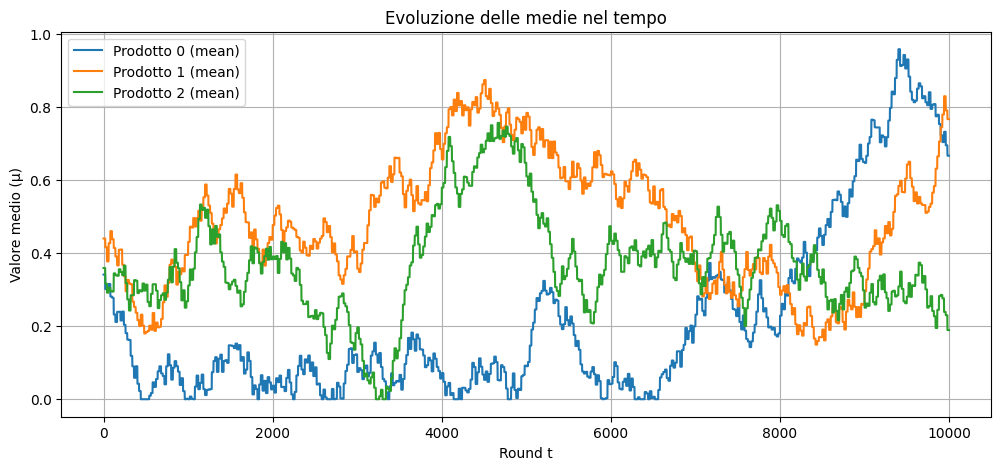

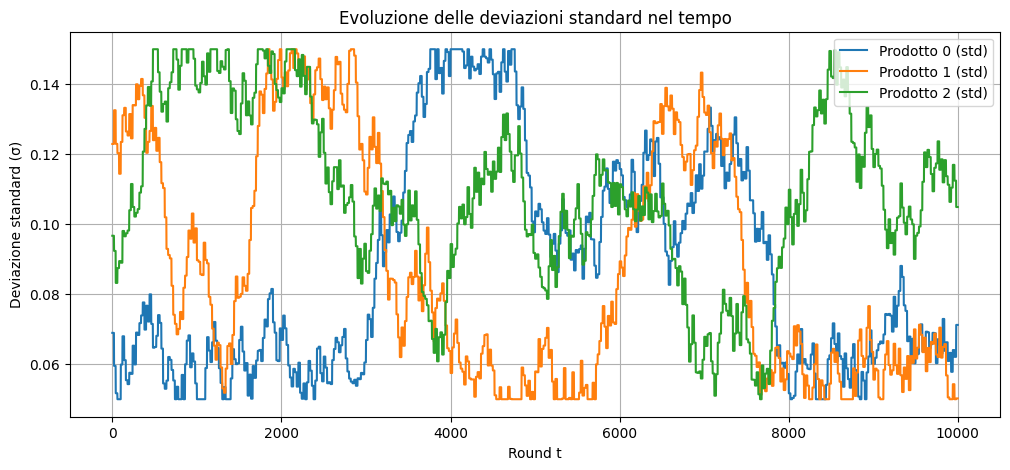

In [ ]:
env = NonStationaryEnvironment(n_products=n_products, T=T, n_intervals=n_intervals)
env.generate_valuations_parameters()

# Plot delle medie
plt.figure(figsize=(12,5))

for p in range(n_products):
    plt.plot(env.means[:, p], label=f"Prodotto {p} (mean)")

plt.title("Evoluzione delle medie nel tempo")
plt.xlabel("Round t")
plt.ylabel("Valore medio (μ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot delle deviazioni standard
plt.figure(figsize=(12,5))

for p in range(n_products):
    plt.plot(env.stds[:, p], label=f"Prodotto {p} (std)")

plt.title("Evoluzione delle deviazioni standard nel tempo")
plt.xlabel("Round t")
plt.ylabel("Deviazione standard (σ)")
plt.legend()
plt.grid(True)
plt.show()